Meltome atlas download doesn't work --> http://meltomeatlas.proteomics.wzw.tum.de:5003/    
ProteomicsDB data is difficult to downlaod --> https://www.proteomicsdb.org/  
PRIDE FTP might contain data needed --> https://www.ebi.ac.uk/pride/archive/projects/PXD011929   




In [1]:
import re
import json
import math

import matplotlib.pyplot as plt

from pathlib import Path
from pandas import read_csv, DataFrame

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from sklearn.model_selection import train_test_split

from helpers import plot_data_statistics

In [2]:
# The UniProt accession regex, used later to extract the uniprot accession from the sequence identifiers
uniprot_accesson_regex = re.compile("([OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2})")

In [3]:
# Where RAW data is stored and where processed data will be deposited
data_path = Path('') / '..' / 'data' / 'meltome'
split_path = Path('') / '..' / 'splits' / 'meltome'


cross_data_path = data_path / 'cross-species.csv'
human_data_path = data_path / 'human.csv'

# For the human data, we need to map gene names to UniProt accessions
# Then we use a TSV export from UniProt to map the sequence to the gene name
human_sequences_path = data_path / 'human_sequences.tsv'

In [4]:
cross_data = read_csv(cross_data_path)
human_data = read_csv(human_data_path)
human_sequences_data = read_csv(human_sequences_path, sep='\t')

/Users/chdallago/miniconda3/envs/bio-benchmarks/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Some data cleaning: remove samples with NaNs
cross_data.dropna(subset=['Protein_ID', 'run_name'], inplace=True)

In [6]:
# Let's have a peek in the "cross data", aka other organisms than human
cross_data[:3]

,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature
0,Bacillus subtilis_168_lysate_R1,C0H3Q1_ytzI,ytzI,NaN,TMT126,0.999203,30.0
1,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT126,0.999203,30.0
2,Bacillus subtilis_168_lysate_R1,C0H3V8_yyzM,yyzM,43.373369,TMT126,0.999203,30.0


In [7]:
# There are multtiple entries for the same protein ID as there are multiple temperature reads
# as well as, potentially, multiple cell lines
cross_data[cross_data['Protein_ID'].str.contains('C0H3V2') == True]

,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature
1,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT126,0.999203,30.0
45627,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT127H,1.102669,36.0
91253,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT127L,1.225128,32.9
136879,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT128H,0.896313,43.2
182505,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT128L,1.317735,39.6
228131,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT129H,0.728182,50.4
273757,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT129L,0.865444,46.8
319383,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT130H,0.402074,57.1
365009,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT130L,0.705247,54.0
410635,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT131L,0.435728,60.0


In [8]:
# Let's have a peek in the human data
human_data[:3]

,gene_name,cell_line_or_type,fold_change,temperature,meltPoint,quan_norm_meltPoint
0,A1CF,HepG2,0.999986,37.0,41.945567,43.719078
1,A1CF,HepG2,0.999986,37.0,42.112354,43.719419
2,A1CF,HepG2,0.999986,37.0,44.141517,43.401106


In [9]:
# There are multtiple entries for the same protein ID as there are multiple temperature reads
# as well as, potentially, multiple cell lines, measured multiple times...
human_data[human_data['gene_name'].str.contains('BRCA')]

,gene_name,cell_line_or_type,fold_change,temperature,meltPoint,quan_norm_meltPoint
17305,BRCA1,HEK293T,0.999986,37.0,47.781019,46.940926
17306,BRCA1,HEK293T,0.999986,37.0,47.352790,46.018048
17307,BRCA1,HL60,0.999986,37.0,46.278582,45.179063
17308,BRCA1,HL60,0.999986,37.0,46.421850,45.237606
17309,BRCA1,Jurkat,0.999986,37.0,46.370902,46.794503
...,...,...,...,...,...,...
1689665,BRCA2,HL60,0.010832,67.0,46.570625,45.417062
1689666,BRCA2,HepG2,0.003576,67.0,54.425721,53.678516
1689667,BRCA2,HepG2,0.014984,67.0,53.319431,52.637081
1689668,BRCA2,HepG2,0.013649,67.0,52.855853,52.421773


In [10]:
# In turn, the melting point may be different, depending on the cell line (or even in the same cell line)
human_data[human_data['gene_name'].str.contains('BRCA')][
    ['cell_line_or_type', 'meltPoint']
].drop_duplicates()

,cell_line_or_type,meltPoint
17305,HEK293T,47.781019
17306,HEK293T,47.352790
17307,HL60,46.278582
17308,HL60,46.421850
17309,Jurkat,46.370902
17310,Jurkat,47.008651
17311,HL60,56.239107
17312,HL60,46.570625
17313,HepG2,54.425721
17314,HepG2,53.319431


In [11]:
# Human data comes with an additional "quan_norm_meltPoint"
human_data[human_data['gene_name'].str.contains('BRCA')][
    ['cell_line_or_type', 'quan_norm_meltPoint']
].drop_duplicates()

,cell_line_or_type,quan_norm_meltPoint
17305,HEK293T,46.940926
17306,HEK293T,46.018048
17307,HL60,45.179063
17308,HL60,45.237606
17309,Jurkat,46.794503
17310,Jurkat,47.579394
17311,HL60,56.973506
17312,HL60,45.417062
17313,HepG2,53.678516
17314,HepG2,52.637081


In [12]:
# If we put it all together
human_data[human_data['gene_name'].str.contains('BRCA')][
    ['cell_line_or_type', 'quan_norm_meltPoint', 'meltPoint']
].drop_duplicates()

,cell_line_or_type,quan_norm_meltPoint,meltPoint
17305,HEK293T,46.940926,47.781019
17306,HEK293T,46.018048,47.352790
17307,HL60,45.179063,46.278582
17308,HL60,45.237606,46.421850
17309,Jurkat,46.794503,46.370902
17310,Jurkat,47.579394,47.008651
17311,HL60,56.973506,56.239107
17312,HL60,45.417062,46.570625
17313,HepG2,53.678516,54.425721
17314,HepG2,52.637081,53.319431


In [13]:
# Get all human proteins from SwissProt (https://www.uniprot.org/uniprot/?query=*&fil=organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+AND+reviewed%3Ayes&sort=score)
# Include: primary gene name and sequence
# Download as TSV!

In [14]:
# It's time to merge sequence data with the gene names
# let's list the columns in the human_sequences data
for column in human_sequences_data.columns:
    print(column)

Entry
Entry name
Status
Protein names
Gene names
Organism
Length
Subcellular location [CC]
Entry.1
Gene names  (primary )
Sequence


In [15]:
gene_sequence_mapping = {}

for gene_name in human_data['gene_name'].unique():
    elements = human_sequences_data[human_sequences_data['Gene names  (primary )'] == gene_name].to_dict('records')
    
    if len(elements) < 1:
        elements = human_sequences_data[human_sequences_data['Gene names'].str.contains(gene_name) == True].to_dict('records')
    
    if len(elements) > 0:
        first_element = elements[0]
        
        gene_sequence_mapping[gene_name] = {
            'uniprotAccession': first_element['Entry'],
            'sequence': first_element['Sequence'],
        }

/Users/chdallago/miniconda3/envs/bio-benchmarks/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Group by run_name and Protein_ID.
The melting point (meltPoint) will be the same for each grouped item
Then, there are the channel, temperature and fold change

## Structure idea:
In JSON format:
```json
{
  proteinId: XX,
  uniprotAccession: ???,
  runName: YY,
  meltingPoint: ZZ,
  quantNormMeltingPoint: KK,
  meltingBehaviour: [
    {
      tempertaure: temp,
      fold_change: fchg,
      channel: channel
    },
    {
      tempertaure: temp,
      fold_change: fchg,
      channel: channel
    },
    ...
  ]
}
```


In [16]:
proteins = list()

In [17]:
# For cross_data

def add_group_to_proteins(group):
    first_hit = group.iloc[0]
    
    melting_behaviour = group[['temperature', 'channel', 'fold_change']].to_dict('records')
    
    protein = {
        'proteinId': first_hit['Protein_ID'],
        'uniprotAccession': None,
        'runName': first_hit['run_name'],
        'meltingPoint': first_hit['meltPoint'],
        'meltingBehaviour': melting_behaviour
    }
    
    uniprot_match = re.search(uniprot_accesson_regex, first_hit['Protein_ID'])
    
    if uniprot_match:
        protein['uniprotAccession'] = uniprot_match.group()
    
    proteins.append(protein)

cross_data.groupby(['Protein_ID', 'run_name']).apply(add_group_to_proteins)

""


In [18]:
# Print all the UniProt Accessions in order to use the UniProt mapping service (https://www.uniprot.org/uploadlists/)
# to download all sequences in bulk

# Uncomment the following to list all possible UniProt accessions
# ";".join([protein['uniprotAccession'] for protein in proteins if protein['uniprotAccession']])

# this resulted in: 34251 out of 34253 UniProtKB AC/ID identifiers were successfully mapped to 34236 UniProtKB IDs in the table below.

In [19]:
sequences_dict = {}

for sequence in SeqIO.parse(data_path / "sequences.fasta", "fasta"):    
    sequences_dict[sequence.id.split('|')[1]] = str(sequence.seq)

In [20]:
for protein in proteins:
    if protein['uniprotAccession']:
        match = sequences_dict.get(protein['uniprotAccession'])
        
        if match:
            protein['sequence'] = match

In [21]:
# For human_data

def add_group_to_proteins(group):
    first_hit = group.iloc[0]
    
    melting_behaviour = group[['temperature', 'fold_change']].to_dict('records')
    
    protein = {
        'proteinId': first_hit['gene_name'],
        'uniprotAccession': None,
        'runName': first_hit['cell_line_or_type'],
        'meltingPoint': first_hit['meltPoint'],
        'quantNormMeltingPoint': first_hit['quan_norm_meltPoint'],
        'meltingBehaviour': melting_behaviour
    }
    
    uniprot_match = gene_sequence_mapping.get(first_hit['gene_name'])
    
    if uniprot_match:
        protein['uniprotAccession'] = uniprot_match['uniprotAccession']
        protein['sequence'] = uniprot_match['sequence']
    
    proteins.append(protein)


human_data.groupby(['gene_name', 'cell_line_or_type', 'meltPoint']).apply(add_group_to_proteins)

""


In [22]:
with open(split_path / "full_dataset.json", "w") as outfile:
    json.dump(proteins, outfile)

In [23]:
protein_sequences = list()

for protein in proteins:
    if protein.get('sequence') \
    and protein.get('meltingPoint') \
    and not math.isnan(protein.get('meltingPoint'))\
    and protein.get('runName'):
        
        protein_sequences.append(
            SeqRecord(
                Seq(protein.get('sequence')),
                id=f"{protein.get('uniprotAccession')}_{'_'.join(protein.get('runName').split(' '))}",
                description=f"MELTING_POINT={protein.get('meltingPoint')}"
            )
        )

In [24]:
SeqIO.write(protein_sequences, split_path / "full_dataset_sequences.fasta", "fasta")

201283

After having run MMSeqs2 to cluster the sequences, we can read in the TSV file to split the dataset

In [25]:
sequence_clusters = read_csv(split_path / "meltome_PIDE20_clusters.tsv", sep="\t")
sequence_clusters.drop_duplicates(inplace=True)

In [26]:
sequence_clusters[sequence_clusters.duplicated("cluster_component")]

,cluster_representative,cluster_component
28424,O60331_HAOEC,Q99755_HAOEC
35560,E9Q9E4_Mus_musculus_BMDC_lysate,P11802_HAOEC


In [27]:
cluster_representatives = sequence_clusters.cluster_representative.unique()
cluster_components = sequence_clusters.cluster_component.unique()

print(f"Theres {len(cluster_representatives)} cluster representatives and "
      f"{len(cluster_components)} sequences in total.")

Theres 15666 cluster representatives and 84030 sequences in total.


In [28]:
train, test = train_test_split(cluster_representatives, test_size=0.2, random_state=11)

# Turn train and test into sets (need to remove from them later)
train = set(train)
test = set(test)

In [29]:
possibilities = set(sequence_clusters.cluster_component.tolist())

In [30]:
clustered_set = list()
full_set = list()
mixed_set = list()

for protein in proteins:
    if protein.get('sequence') \
    and protein.get('meltingPoint') \
    and not math.isnan(protein.get('meltingPoint'))\
    and protein.get('runName'):
        
        key = f"{protein.get('uniprotAccession')}_{'_'.join(protein.get('runName').split(' '))}"
        
        if key in possibilities:
            hits = sequence_clusters[sequence_clusters.cluster_component == key].values
            cluster_rep_key = hits[0][0]

            if cluster_rep_key in train:
                full_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'train'
                })
                
                mixed_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'train'
                })
            elif cluster_rep_key in test:
                full_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'test'
                })

            possibilities.remove(key)

            if key in train:
                clustered_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'train'
                })
                train.remove(key)
            elif key in test:
                clustered_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'test'
                })
                
                mixed_set.append({
                    'sequence': protein.get('sequence'),
                    'target': protein.get('meltingPoint'),
                    'set': 'test'
                })
                test.remove(key)

,sequence,target,set,validation
0,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...,37.962947,train,NaN
1,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...,54.425342,train,NaN
2,MRICFLLLAFLVAETFANELTRCCAGGTRHFKNSNTCSSIKSEGTS...,49.459216,train,NaN


The test set will be 11.21% of the data (3134 out of 27951 samples).


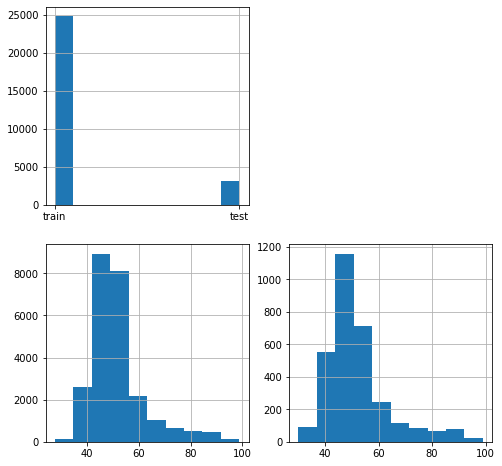

In [31]:
# Turn dictionary into dataframe
mixed_set_df = DataFrame.from_records(mixed_set)

# Get 10% validation from training:
train_indices = mixed_set_df.query('set=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
mixed_set_df.loc[val_indices, 'validation'] = True

mixed_set_df.to_csv(split_path / 'splits' / 'mixed_split.csv', index=False)

# Let's inspect the dataframe
display(mixed_set_df[:3])

# Plot statistics
plot_data_statistics(mixed_set_df, 'set', 'target')